In [1]:
from typing import Iterator, List, Union, Tuple, Any
from datetime import datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History

### Useful Links
- https://rosenfelder.ai/keras-regression-efficient-net/
- https://github.com/MarkusRosen/keras-efficientnet-regression
- https://towardsdatascience.com/image-classification-transfer-learning-and-fine-tuning-using-tensorflow-a791baf9dbf3
- https://pyimagesearch.com/2019/05/27/keras-feature-extraction-on-large-datasets-with-deep-learning/

# Data Collection

### Data Source: https://www.kaggle.com/c/bone-age-regression/data

In [2]:
df = pd.read_csv('data/train.csv')
df = df.sort_values(by='fileName')[:200]
df

,fileName,boneage,male
3957,10000.png,96,True
10831,10001.png,168,True
132,10002.png,168,True
3494,10003.png,76,False
9580,10004.png,135,True
...,...,...,...
804,10243.png,132,False
11176,10244.png,162,True
1931,10245.png,96,True
2991,10246.png,108,True


In [290]:
# ENDED UP NOT USED

df_pred = pd.read_csv('data/test.csv')
df_pred_sorted = df_pred.sort_values('fileName')[:19]
df_pred_sorted

,fileName,male
852,10007.png,True
1220,10017.png,False
463,10019.png,True
824,10030.png,False
999,10037.png,False
319,10059.png,True
809,10069.png,False
482,10108.png,True
1192,10120.png,True
1254,10132.png,False


# Data Preprocessing

### Credit: - https://github.com/MarkusRosen/keras-efficientnet-regression

In [4]:
def split_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Accepts a Pandas DataFrame and splits it into training, testing and validation data. Returns DataFrames.
    Parameters
    ----------
    df : pd.DataFrame
        Your Pandas DataFrame containing all your data.
    Returns
    -------
    Union[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        [description]
    """
    train, val = train_test_split(df, test_size=0.2, random_state=1)  # split the data with a validation size o 20%
    train, test = train_test_split(
        train, test_size=0.125, random_state=1
    )  # split the data with an overall  test size of 10%

    print("shape train: ", train.shape)  # type: ignore
    print("shape val: ", val.shape)  # type: ignore
    print("shape test: ", test.shape)  # type: ignore

    print("Descriptive statistics of train:")
    print(train.describe())  # type: ignore
    return train, val, test  # type: ignore

In [5]:
train, val, test = split_data(df)
train.head()

shape train:  (140, 3)
shape val:  (40, 3)
shape test:  (20, 3)
Descriptive statistics of train:
          boneage
count  140.000000
mean   126.821429
std     44.410652
min     10.000000
25%     95.500000
50%    132.000000
75%    162.000000
max    228.000000


,fileName,boneage,male
10181,10095.png,204,True
1886,10140.png,120,False
5459,10046.png,132,True
10420,10023.png,180,True
9843,10180.png,168,True


In [6]:
def create_generators(train: pd.DataFrame, val: pd.DataFrame, test: pd.DataFrame) -> Tuple[Iterator, Iterator, Iterator]:
    """Accepts four Pandas DataFrames: all your data, the training, validation and test DataFrames. Creates and returns
    keras ImageDataGenerators. Within this function you can also visualize the augmentations of the ImageDataGenerators.
    Parameters
    ----------
    df : pd.DataFrame
        Your Pandas DataFrame containing all your data.
    train : pd.DataFrame
        Your Pandas DataFrame containing your training data.
    val : pd.DataFrame
        Your Pandas DataFrame containing your validation data.
    test : pd.DataFrame
        Your Pandas DataFrame containing your testing data.
    Returns
    -------
    Tuple[Iterator, Iterator, Iterator]
        keras ImageDataGenerators used for training, validating and testing of your models.
    """
    train_generator = ImageDataGenerator(
        rescale=1.0 / 255,
#         rotation_range=5,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         brightness_range=(0.75, 1),
#         shear_range=0.1,
#         zoom_range=[0.75, 1],
#         horizontal_flip=True,
#         validation_split=0.2,
    )  # create an ImageDataGenerator with multiple image augmentations
    validation_generator = ImageDataGenerator(rescale=1.0 / 255)
    test_generator = ImageDataGenerator(rescale=1.0 / 255)
    
    directory = './data/img'

    train_generator = train_generator.flow_from_dataframe(
        dataframe=train,
        directory=directory,
        x_col="fileName",  # this is where your image data is stored
        y_col="boneage",  # this is your target feature
        class_mode="raw",  # use "raw" for regressions
        target_size=(224, 224),
#         batch_size=32,  # increase or decrease to fit your GPU
#         validate_filenames=False
    )
    
    validation_generator = validation_generator.flow_from_dataframe(
        dataframe=val, 
        directory=directory,
        x_col="fileName", 
        y_col="boneage", 
        class_mode="raw", 
        target_size=(224, 224), 
#         batch_size=128,
#         validate_filenames=False
    )
    
    test_generator = test_generator.flow_from_dataframe(
        dataframe=test, 
        directory=directory,
        x_col="fileName",
        y_col="boneage", 
        class_mode="raw",
        target_size=(224, 224),
#         batch_size=128,
#         validate_filenames=False
    )
    
    return train_generator, validation_generator, test_generator

In [7]:
train_generator, validation_generator, test_generator = create_generators(train, val, test)

Found 140 validated image filenames.
Found 40 validated image filenames.
Found 20 validated image filenames.


# Modeling

In [175]:
def bone_cnn() -> Sequential:
    """A very small custom convolutional neural network with image input dimensions of 224x224x3.
    Returns
    -------
    Sequential
        The keras Sequential model.
    """
    model = models.Sequential()
    model.add(layers.Conv2D(128, (3, 3), activation="relu", input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))

    return model

In [180]:
model = bone_cnn()
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 54, 54, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 52, 52, 256)       590080    
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 26, 26, 256)    

In [181]:
model.compile(loss='mean_absolute_error', metrics=[MeanAbsoluteError()])

## First 50 Epochs

In [182]:
hist = model.fit(
    train_generator, 
    epochs=50, 
    validation_data=validation_generator, 
#     callbacks=callbacks,
    workers=4
)

Epoch 1/50
5/5 [==============================] - 200s 45s/step - loss: 473.1548 - mean_absolute_error: 428.8510 - val_loss: 91.7125 - val_mean_absolute_error: 88.9710
Epoch 2/50
5/5 [==============================] - 232s 47s/step - loss: 64.5656 - mean_absolute_error: 64.0311 - val_loss: 48.5661 - val_mean_absolute_error: 40.3580
Epoch 3/50
5/5 [==============================] - 166s 32s/step - loss: 41.3116 - mean_absolute_error: 41.3506 - val_loss: 42.9595 - val_mean_absolute_error: 41.1458
Epoch 4/50
5/5 [==============================] - 166s 33s/step - loss: 45.1148 - mean_absolute_error: 47.3927 - val_loss: 42.9687 - val_mean_absolute_error: 40.9678
Epoch 5/50
5/5 [==============================] - 165s 32s/step - loss: 57.1699 - mean_absolute_error: 55.4068 - val_loss: 42.4949 - val_mean_absolute_error: 43.6454
Epoch 6/50
5/5 [==============================] - 164s 32s/step - loss: 54.5439 - mean_absolute_error: 55.2958 - val_loss: 91.1721 - val_mean_absolute_error: 93.4844
Ep

## 70 Epochs (50 + 20)

In [187]:
hist_70 = model.fit(
    train_generator, 
    epochs=20, 
    validation_data=validation_generator, 
#     callbacks=callbacks,
    workers=4
)

Epoch 1/20
5/5 [==============================] - 212s 49s/step - loss: 38.1142 - mean_absolute_error: 37.8270 - val_loss: 40.2223 - val_mean_absolute_error: 35.5536
Epoch 2/20
5/5 [==============================] - 184s 37s/step - loss: 42.8524 - mean_absolute_error: 45.9788 - val_loss: 54.0397 - val_mean_absolute_error: 52.4850
Epoch 3/20
5/5 [==============================] - 193s 44s/step - loss: 52.1763 - mean_absolute_error: 53.4075 - val_loss: 68.9681 - val_mean_absolute_error: 70.4049
Epoch 4/20
5/5 [==============================] - 194s 39s/step - loss: 47.3948 - mean_absolute_error: 45.1616 - val_loss: 30.7590 - val_mean_absolute_error: 25.6100
Epoch 5/20
5/5 [==============================] - 186s 38s/step - loss: 48.3551 - mean_absolute_error: 47.4300 - val_loss: 31.2535 - val_mean_absolute_error: 34.7706
Epoch 6/20
5/5 [==============================] - 167s 33s/step - loss: 36.4899 - mean_absolute_error: 36.6196 - val_loss: 51.8049 - val_mean_absolute_error: 51.6381
Epoc

## 90 Epochs (50 + 20 + 20)

In [195]:
hist_90 = model.fit(
    train_generator, 
    epochs=20, 
    validation_data=validation_generator, 
#     callbacks=callbacks,
    workers=4
)

Epoch 1/20
5/5 [==============================] - 172s 33s/step - loss: 37.8656 - mean_absolute_error: 37.1810 - val_loss: 29.0611 - val_mean_absolute_error: 24.1985
Epoch 2/20
5/5 [==============================] - 179s 36s/step - loss: 42.1499 - mean_absolute_error: 40.8258 - val_loss: 27.9815 - val_mean_absolute_error: 27.5409
Epoch 3/20
5/5 [==============================] - 180s 41s/step - loss: 40.1521 - mean_absolute_error: 38.8630 - val_loss: 28.2397 - val_mean_absolute_error: 28.7537
Epoch 4/20
5/5 [==============================] - 216s 42s/step - loss: 50.4977 - mean_absolute_error: 48.2911 - val_loss: 30.7421 - val_mean_absolute_error: 29.4113
Epoch 5/20
5/5 [==============================] - 200s 39s/step - loss: 37.5126 - mean_absolute_error: 35.7336 - val_loss: 27.1947 - val_mean_absolute_error: 24.4773
Epoch 6/20
5/5 [==============================] - 201s 39s/step - loss: 39.0722 - mean_absolute_error: 38.7654 - val_loss: 27.9934 - val_mean_absolute_error: 29.9467
Epoc

### 90 Epochs Result

In [196]:
model.evaluate(test_generator)

1/1 [==============================] - 7s 7s/step - loss: 32.7033 - mean_absolute_error: 32.7033


[32.70326232910156, 32.70326232910156]

## 150 Epochs (50 + 20 + 20 + 60)
Continued from yesterday's training

In [12]:
## Continue Training for Tomorrow (5/3/2022)

model = load_model('model/model_medium_90_epochs.h5', compile=False)
model.compile(loss='mean_absolute_error', metrics=[MeanAbsoluteError()])

In [13]:
hist_150 = model.fit(
    train_generator, 
    epochs=60, 
    validation_data=validation_generator, 
#     callbacks=callbacks,
    workers=3
)

Epoch 1/60
5/5 [==============================] - 173s 33s/step - loss: 83.5851 - mean_absolute_error: 77.2875 - val_loss: 28.9512 - val_mean_absolute_error: 32.0961
Epoch 2/60
5/5 [==============================] - 193s 36s/step - loss: 36.4306 - mean_absolute_error: 34.9081 - val_loss: 35.8249 - val_mean_absolute_error: 36.6276
Epoch 3/60
5/5 [==============================] - 193s 37s/step - loss: 28.0266 - mean_absolute_error: 26.5719 - val_loss: 45.8072 - val_mean_absolute_error: 42.5839
Epoch 4/60
5/5 [==============================] - 184s 35s/step - loss: 47.9675 - mean_absolute_error: 46.6652 - val_loss: 48.6700 - val_mean_absolute_error: 46.3137
Epoch 5/60
5/5 [==============================] - 187s 37s/step - loss: 37.9036 - mean_absolute_error: 37.7426 - val_loss: 43.2055 - val_mean_absolute_error: 46.1213
Epoch 6/60
5/5 [==============================] - 206s 42s/step - loss: 37.2198 - mean_absolute_error: 37.5666 - val_loss: 46.8658 - val_mean_absolute_error: 40.5528
Epoc

5/5 [==============================] - 180s 35s/step - loss: 21.8362 - mean_absolute_error: 21.6385 - val_loss: 52.1138 - val_mean_absolute_error: 52.4077
Epoch 51/60
5/5 [==============================] - 188s 37s/step - loss: 24.9379 - mean_absolute_error: 24.1893 - val_loss: 25.1331 - val_mean_absolute_error: 20.2089
Epoch 52/60
5/5 [==============================] - 184s 35s/step - loss: 28.7089 - mean_absolute_error: 31.1640 - val_loss: 31.3519 - val_mean_absolute_error: 30.5061
Epoch 53/60
5/5 [==============================] - 192s 37s/step - loss: 25.7205 - mean_absolute_error: 25.4360 - val_loss: 26.2497 - val_mean_absolute_error: 26.1348
Epoch 54/60
5/5 [==============================] - 204s 41s/step - loss: 33.8657 - mean_absolute_error: 33.1374 - val_loss: 27.5580 - val_mean_absolute_error: 30.3085
Epoch 55/60
5/5 [==============================] - 184s 41s/step - loss: 27.8812 - mean_absolute_error: 26.6909 - val_loss: 35.9411 - val_mean_absolute_error: 35.2003
Epoch 56/6

### 150 Epochs Result

In [14]:
model.evaluate(test_generator)

1/1 [==============================] - 7s 7s/step - loss: 21.2716 - mean_absolute_error: 21.2716


[21.271625518798828, 21.271625518798828]

### Save 150 Epochs Trained Medium Model

In [16]:
model.save("model/model_medium_150_epochs.h5")
print("Saved model to disk")

Saved model to disk


### Visualize 150 Epochs History

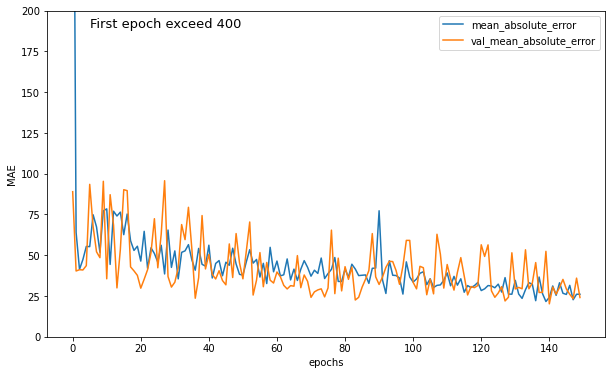

In [69]:
data = pd.read_csv('model/medium_cnn_150_epochs_history.csv')

plt.figure(figsize=(10, 6))
# data['loss'][1:].plot()
# data['val_loss'][1:].plot()
data['mean_absolute_error'][:].plot()
data['val_mean_absolute_error'][:].plot()
plt.legend(['mean_absolute_error', 'val_mean_absolute_error'])
plt.gca().set_ylim([0, 200])
plt.annotate('First epoch exceed 400',
             xy=(5, 190), 
             size=13)
plt.xlabel("epochs")
plt.ylabel("MAE")
plt.show()

# Transfer Learning
- https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/
- https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

In [134]:
def pretrain_model() -> Sequential:
    """A very small custom convolutional neural network with image input dimensions of 224x224x3.
    Returns
    -------
    Sequential
        The keras Sequential model.
    """
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation="relu", input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
#     model.add(layers.Dense(64, activation="relu"))
#     model.add(layers.Dense(64, activation="relu"))
#     model.add(layers.Dense(1))

    return model

In [135]:
model_test = pretrain_model()

In [136]:
model_test.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 373248)            0         
                                                                 
Total params: 75,648
Trainable params: 75,648
Non-trai

In [137]:
vectors = model_test.predict(test_generator)

In [140]:
print(len(vectors[0]))
gender_vector = 1
x = np.append(vectors[1], gender_vector)
print(x)
print(len(x))

373248
[0.         0.06036194 0.05149771 ... 0.         0.11038003 1.        ]
373249


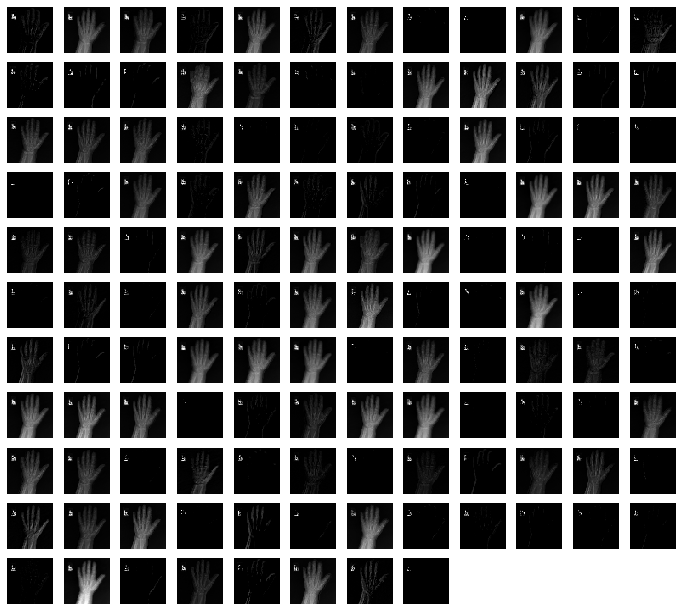

In [128]:
sample = vectors[0] # first data

plt.figure(figsize=(12, 12))

for channel in range(vectors.shape[-1]):
    channel_img = sample[:,:,channel]
    plt.subplot(12, 12, channel+1)
    plt.axis(False)
    plt.imshow(channel_img, interpolation="nearest", cmap='gray')

plt.savefig('last-layer-examples.png')        
plt.show()

# Feature Extraction
- https://stackoverflow.com/questions/9638826/plot-a-black-and-white-binary-map-in-matplotlib
- https://stackoverflow.com/questions/37971541/how-does-the-indexing-of-subplots-work
- https://stackoverflow.com/questions/18266642/multiple-imshow-subplots-each-with-colorbar
- https://www.analyticsvidhya.com/blog/2020/11/tutorial-how-to-visualize-feature-maps-directly-from-cnn-layers/
- https://stackoverflow.com/questions/59930781/how-to-extract-features-from-an-image-for-training-a-cnn-model
- https://medium.com/bisa-ai/feature-map-pada-convolutional-neural-network-cnn-e3c000e914a

### Layer 1

In [284]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[0].output)
model_feature.summary()

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
Total params: 3,584
Trainable params: 3,584
Non-trainable params: 0
_________________________________________________________________


In [285]:
feature_map = model_feature.predict(test_generator)

In [286]:
feature_map.shape

(20, 222, 222, 128)

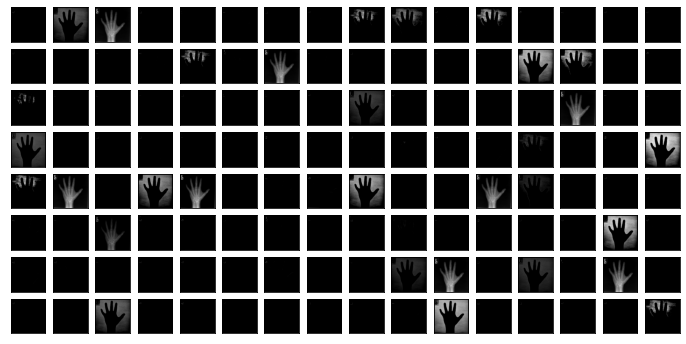

In [287]:
size_x = 8
size_y = 16
index = 1
plt.figure(figsize=(12, 6))

for _ in range(size_x):
    for _ in range(size_y):
        axs = plt.subplot(size_x,size_y,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 2

In [282]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[1].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
Total params: 3,584
Trainable params: 3,584
Non-trainable params: 0
_________________________________________________________________
(20, 111, 111, 128)


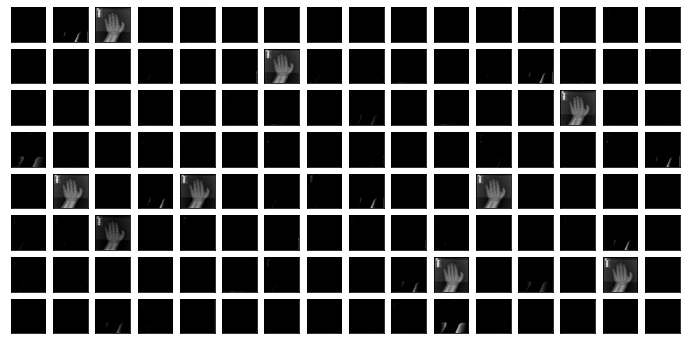

In [283]:
size_x = 8
size_y = 16
index = 1
plt.figure(figsize=(12, 6))

for _ in range(size_x):
    for _ in range(size_y):
        axs = plt.subplot(size_x,size_y,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 3

In [254]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[2].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
Total params: 298,752
Trainable params: 298,752
Non-trainable params: 0
_________________________________________________________________
(20, 109, 109, 256)


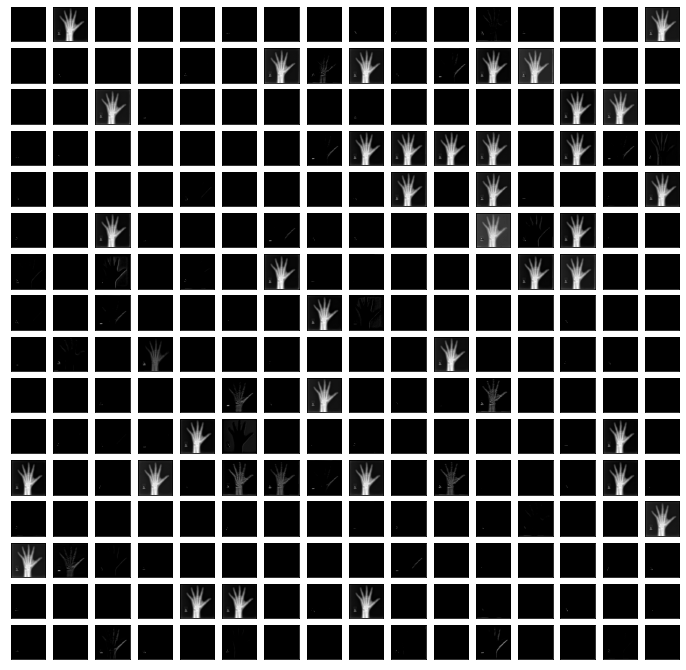

In [255]:
size = 16 # 256 channels displayed
index = 1
plt.figure(figsize=(12, 12))

for _ in range(size):
    for _ in range(size):
        axs = plt.subplot(size,size,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 4

In [256]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[3].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 54, 54, 256)      0         
 g2D)                                                            
                                                          

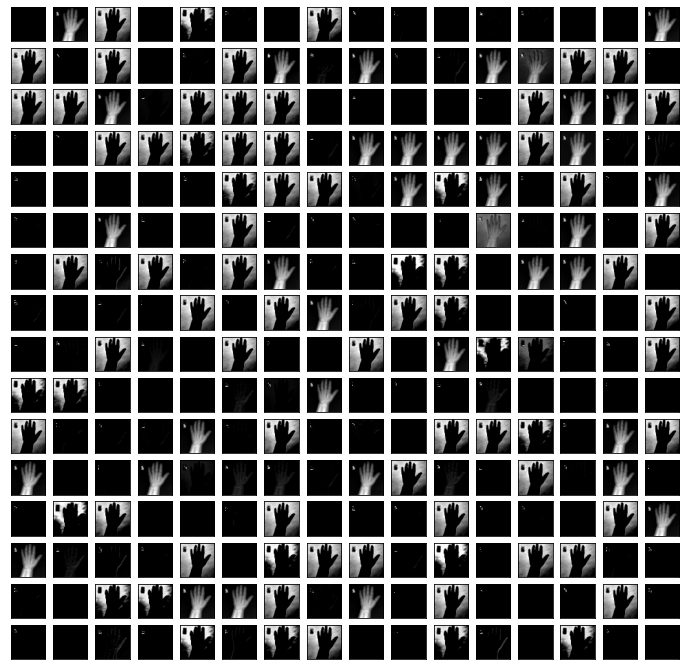

In [257]:
size = 16
index = 1
plt.figure(figsize=(12, 12))

for _ in range(size):
    for _ in range(size):
        axs = plt.subplot(size,size,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 5

In [258]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[4].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 54, 54, 256)      0         
 g2D)                                                            
                                                          

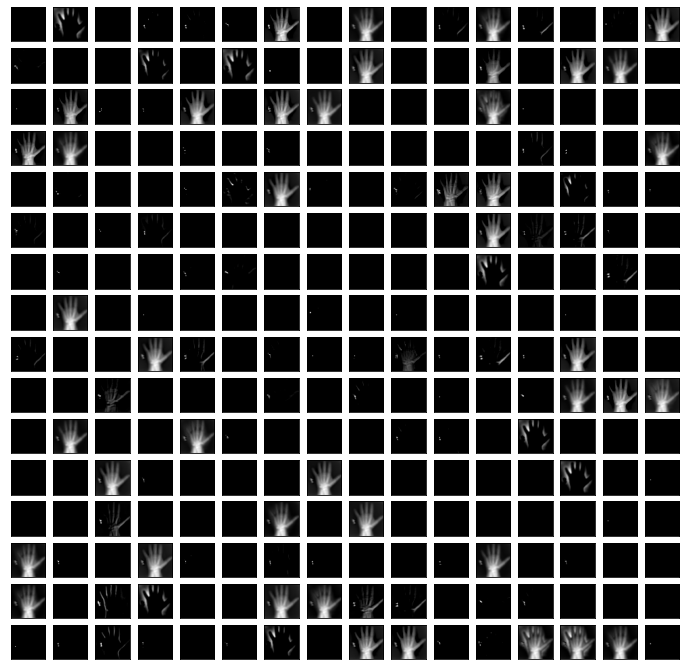

In [259]:
size = 16
index = 1
plt.figure(figsize=(12, 12))

for _ in range(size):
    for _ in range(size):
        axs = plt.subplot(size,size,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 6

In [280]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[5].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 54, 54, 256)      0         
 g2D)                                                            
                                                          

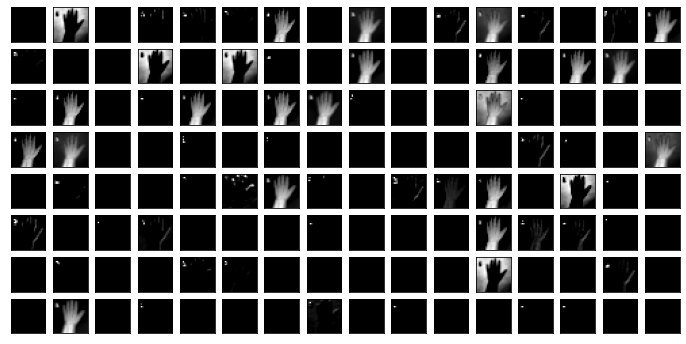

In [281]:
size_x = 8
size_y = 16
index = 1
plt.figure(figsize=(12, 6))

for _ in range(size_x):
    for _ in range(size_y):
        axs = plt.subplot(size_x,size_y,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 7

In [278]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[6].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 54, 54, 256)      0         
 g2D)                                                            
                                                          

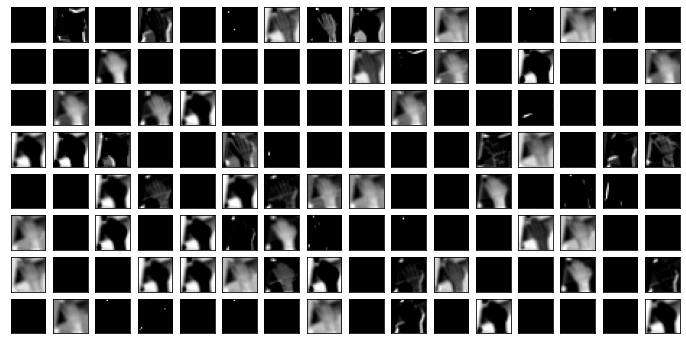

In [279]:
size_x = 8
size_y = 16
index = 1
plt.figure(figsize=(12, 6))

for _ in range(size_x):
    for _ in range(size_y):
        axs = plt.subplot(size_x,size_y,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 8

In [275]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[7].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 54, 54, 256)      0         
 g2D)                                                            
                                                          

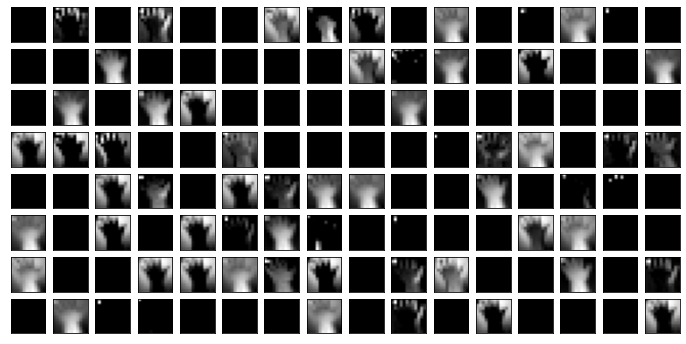

In [276]:
size_x = 8
size_y = 16
index = 1
plt.figure(figsize=(12, 6))

for _ in range(size_x):
    for _ in range(size_y):
        axs = plt.subplot(size_x,size_y,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 9

In [266]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[8].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 54, 54, 256)      0         
 g2D)                                                            
                                                          

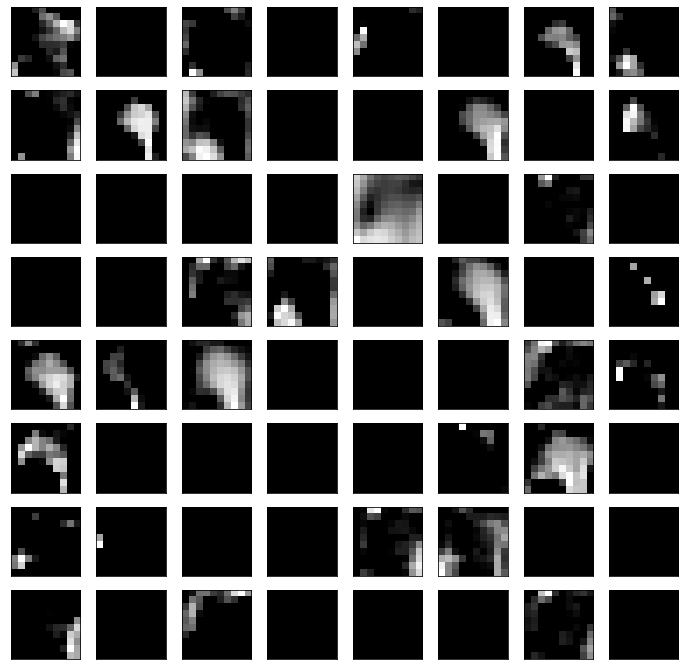

In [267]:
size_x = 8
size_y = 8
index = 1
plt.figure(figsize=(12, 12))

for _ in range(size_x):
    for _ in range(size_y):
        axs = plt.subplot(size_x,size_y,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 10

In [268]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[9].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 54, 54, 256)      0         
 g2D)                                                            
                                                          

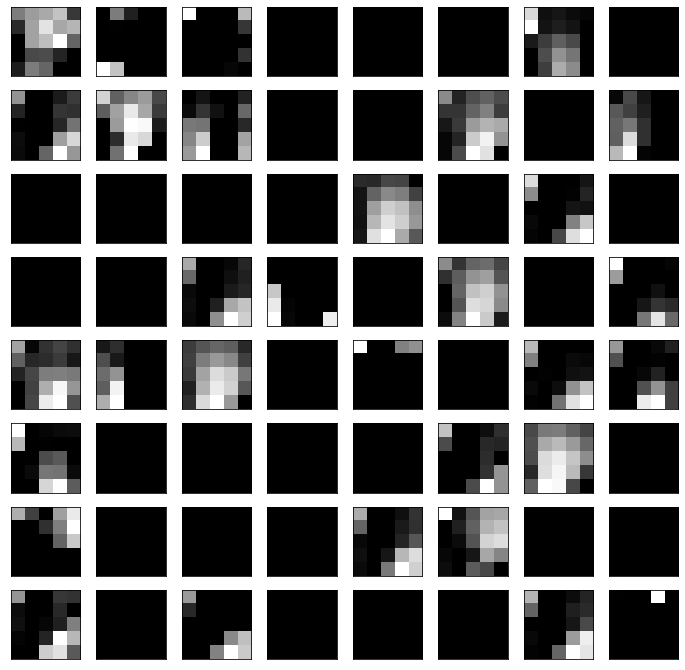

In [269]:
size_x = 8
size_y = 8
index = 1
plt.figure(figsize=(12, 12))

for _ in range(size_x):
    for _ in range(size_y):
        axs = plt.subplot(size_x,size_y,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()